In [79]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras import backend as K
from keras.models import load_model
import utils
import util
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='keras')

In [5]:
# Load the dataset
train_df = pd.read_csv("train-small.csv")
valid_df = pd.read_csv("valid-small.csv")

test_df = pd.read_csv("test.csv")

train_df.head()

,Image,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,PatientId,Pleural_Thickening,Pneumonia,Pneumothorax
0,00008270_015.png,0,0,0,0,0,0,0,0,0,0,0,8270,0,0,0
1,00029855_001.png,1,0,0,0,1,0,0,0,1,0,0,29855,0,0,0
2,00001297_000.png,0,0,0,0,0,0,0,0,0,0,0,1297,1,0,0
3,00012359_002.png,0,0,0,0,0,0,0,0,0,0,0,12359,0,0,0
4,00017951_001.png,0,0,0,0,0,0,0,0,1,0,0,17951,0,0,0


In [7]:
labels = ['Cardiomegaly', 
          'Emphysema', 
          'Effusion', 
          'Hernia', 
          'Infiltration', 
          'Mass', 
          'Nodule', 
          'Atelectasis',
          'Pneumothorax',
          'Pleural_Thickening', 
          'Pneumonia', 
          'Fibrosis', 
          'Edema', 
          'Consolidation']

### Check for data leakage and patient overlap 

In [10]:
def check_for_leakage(df1, df2, patient_col):
    df1_patients_unique = set(df1[patient_col])
    df2_patients_unique = set(df2[patient_col])
    patients_in_both_groups = df1_patients_unique.intersection(df2_patients_unique)

    # leakage contains true if there is patient overlap, otherwise false.
    if patients_in_both_groups:
        leakage = True # true if there is at least 1 patient in both groups
    else:
        leakage = False
    
    return leakage

print("leakage between train and test: {}".format(check_for_leakage(train_df, test_df, 'PatientId')))
print("leakage between valid and test: {}".format(check_for_leakage(valid_df, test_df, 'PatientId')))
print("-------------------------------------")
# Extract patient id's for the training set
ids_train = train_df.PatientId.values

# Extract patient id's for the validation set
ids_valid = valid_df.PatientId.values

# Create a "set" datastructure of the training set id's to identify unique id's
ids_train_set = set(ids_train)
print(f'There are {len(ids_train_set)} unique Patient IDs in the training set')

# Create a "set" datastructure of the validation set id's to identify unique id's
ids_valid_set = set(ids_valid)
print(f'There are {len(ids_valid_set)} unique Patient IDs in the validation set')

# Identify patient overlap by looking at the intersection between the sets
patient_overlap = list(ids_train_set.intersection(ids_valid_set))
n_overlap = len(patient_overlap)
print(f'There are {n_overlap} Patient IDs in both the training and validation sets')
print('')
print(f'These patients are in both the training and validation datasets:')
print(f'{patient_overlap}')
print("-------------------------------------")
train_overlap_idxs = []
valid_overlap_idxs = []
for idx in range(n_overlap):
    train_overlap_idxs.extend(train_df.index[train_df['PatientId'] == patient_overlap[idx]].tolist())
    valid_overlap_idxs.extend(valid_df.index[valid_df['PatientId'] == patient_overlap[idx]].tolist())
    
# Drop the overlapping rows from the validation set
valid_df.drop(valid_overlap_idxs, inplace=True)

# Extract patient id's for the validation set
ids_valid = valid_df.PatientId.values

# Create a "set" datastructure of the validation set id's to identify unique id's
ids_valid_set = set(ids_valid)
print(f'There are {len(ids_valid_set)} unique Patient IDs in the validation set')
print("-------------------------------------")
# Identify patient overlap by looking at the intersection between the sets
patient_overlap = list(ids_train_set.intersection(ids_valid_set))
n_overlap = len(patient_overlap)
print(f'There are {n_overlap} Patient IDs in both the training and validation sets')

leakage between train and test: False
leakage between valid and test: False
-------------------------------------
There are 928 unique Patient IDs in the training set
There are 199 unique Patient IDs in the validation set
There are 197 Patient IDs in both the training and validation sets

These patients are in both the training and validation datasets:
[17920, 15360, 17417, 28682, 16397, 27665, 25628, 22559, 22047, 17951, 17443, 8741, 8230, 22572, 25645, 28208, 11315, 10294, 2614, 8760, 15929, 10808, 26685, 17470, 8767, 19014, 12359, 26185, 1610, 17997, 8270, 27725, 13904, 589, 18000, 20052, 12379, 25695, 13408, 27235, 4195, 11366, 6761, 22135, 26232, 121, 5241, 27260, 10877, 5759, 16007, 10888, 1168, 2705, 658, 25746, 9365, 11420, 8348, 16030, 29855, 16034, 12966, 29865, 28844, 3759, 9911, 14520, 9912, 26810, 1212, 12487, 26825, 1738, 21195, 28876, 30415, 1232, 720, 26835, 25813, 16604, 20188, 25315, 17126, 9447, 15078, 18669, 17135, 20213, 21750, 4344, 4858, 27900, 25858, 4360, 2312,

### Preparing images

In [13]:
def get_train_generator(df, image_dir, x_col, y_cols, shuffle=True, batch_size=8, seed=1, target_w = 320, target_h = 320):    
    print("getting train generator...") 
    # normalize images
    image_generator = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization= True)
    
    # flow from directory with specified batch size
    # and target image size
    generator = image_generator.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            target_size=(target_w,target_h))
    
    return generator


In [15]:
def get_test_and_valid_generator(valid_df, test_df, train_df, image_dir, x_col, y_cols, sample_size=100, batch_size=8, seed=1, target_w = 320, target_h = 320):
    
    print("getting train and valid generators...")
    # get generator to sample dataset
    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df, 
        directory=IMAGE_DIR, 
        x_col="Image", 
        y_col=labels, 
        class_mode="raw", 
        batch_size=sample_size, 
        shuffle=True, 
        target_size=(target_w, target_h))
    
    # get data sample
    batch = next(raw_train_generator)
    data_sample = batch[0]

    # use sample to fit mean and std for test set generator
    image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization= True)
    
    # fit generator to sample from training data
    image_generator.fit(data_sample)

    # get test generator
    valid_generator = image_generator.flow_from_dataframe(
            dataframe=valid_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))

    test_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))
    return valid_generator, test_generator

In [17]:
IMAGE_DIR = "images-small"
train_generator = get_train_generator(train_df, IMAGE_DIR, "Image", labels)
valid_generator, test_generator= get_test_and_valid_generator(valid_df, test_df, train_df, IMAGE_DIR, "Image", labels)

getting train generator...
Found 1000 validated image filenames.
getting train and valid generators...
Found 1000 validated image filenames.
Found 2 validated image filenames.
Found 420 validated image filenames.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9120169..1.9989136].


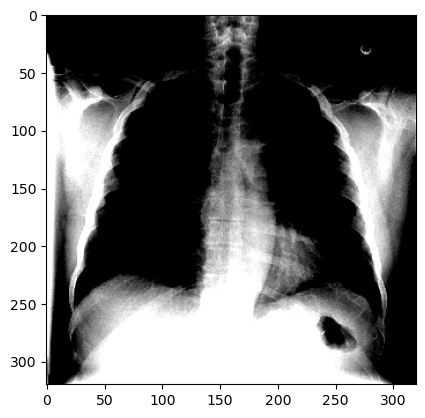

In [19]:
x, y = train_generator.__getitem__(0)
plt.imshow(x[0]);

In [21]:
# Count up the number of instances of each class (drop non-class columns from the counts)
class_counts = train_df.sum().drop(['Image','PatientId'])
for column in class_counts.keys():
    print(f"The class {column} has {train_df[column].sum()} samples")

The class Atelectasis has 106 samples
The class Cardiomegaly has 20 samples
The class Consolidation has 33 samples
The class Edema has 16 samples
The class Effusion has 128 samples
The class Emphysema has 13 samples
The class Fibrosis has 14 samples
The class Hernia has 2 samples
The class Infiltration has 175 samples
The class Mass has 45 samples
The class Nodule has 54 samples
The class Pleural_Thickening has 21 samples
The class Pneumonia has 10 samples
The class Pneumothorax has 38 samples


### Class Imbalance

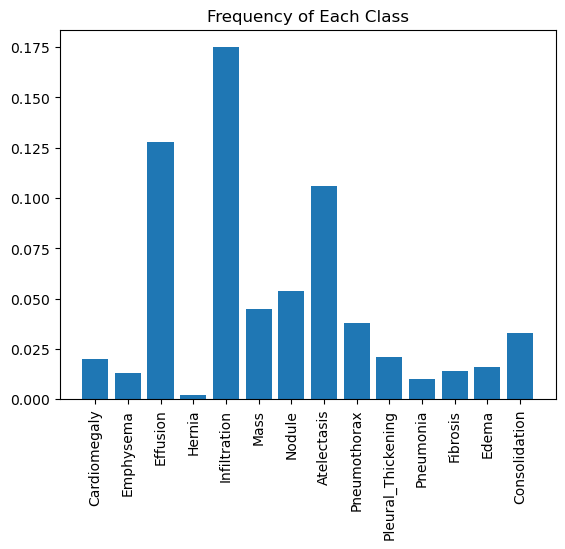

In [24]:
plt.xticks(rotation=90)
plt.bar(x=labels, height=np.mean(train_generator.labels, axis=0))
plt.title("Frequency of Each Class")
plt.show()

We can see from this plot that the prevalance of positive cases varies significantly across the different pathologies. (These trends mirror the ones in the full dataset as well.) 
* The `Hernia` pathology has the greatest imbalance with the proportion of positive training cases being about 0.2%. 
* But even the `Infiltration` pathology, which has the least amount of imbalance, has only 17.5% of the training cases labelled positive.

Ideally, we would train our model using an evenly balanced dataset so that the positive and negative training cases would contribute equally to the loss. 

If we use a normal cross-entropy loss function with a highly unbalanced dataset, as we are seeing here, then the algorithm will be incentivized to prioritize the majority class (i.e negative in our case), since it contributes more to the loss. 

#### Impact of class imbalance on loss function

Let's take a closer look at this. Assume we would have used a normal cross-entropy loss for each pathology. We recall that the cross-entropy loss contribution from the $i^{th}$ training data case is:

$$\mathcal{L}_{cross-entropy}(x_i) = -(y_i \log(f(x_i)) + (1-y_i) \log(1-f(x_i))),$$

where $x_i$ and $y_i$ are the input features and the label, and $f(x_i)$ is the output of the model, i.e. the probability that it is positive. 

Note that for any training case, either $y_i=0$ or else $(1-y_i)=0$, so only one of these terms contributes to the loss (the other term is multiplied by zero, and becomes zero). 

We can rewrite the overall average cross-entropy loss over the entire training set $\mathcal{D}$ of size $N$ as follows: 

$$\mathcal{L}_{cross-entropy}(\mathcal{D}) = - \frac{1}{N}\big( \sum_{\text{positive examples}} \log (f(x_i)) + \sum_{\text{negative examples}} \log(1-f(x_i)) \big).$$

Using this formulation, we can see that if there is a large imbalance with very few positive training cases, for example, then the loss will be dominated by the negative class. Summing the contribution over all the training cases for each class (i.e. pathological condition), we see that the contribution of each class (i.e. positive or negative) is: 

$$freq_{p} = \frac{\text{number of positive examples}}{N} $$

$$\text{and}$$

$$freq_{n} = \frac{\text{number of negative examples}}{N}.$$

### Computing Class Frequencies

In [29]:
def compute_class_freqs(labels):
    # Total number of patients (rows)
    N = labels.shape[0]
    
    positive_frequencies = np.sum(labels, axis=0) / N
    negative_frequencies = 1 - positive_frequencies

    return positive_frequencies, negative_frequencies

# Test data
labels_matrix = np.array(
    [[1, 0, 0],
     [0, 1, 1],
     [1, 0, 1],
     [1, 1, 1],
     [1, 0, 1]]
)
print("Labels:")
print(labels_matrix)

# Compute frequencies
test_pos_freqs, test_neg_freqs = compute_class_freqs(labels_matrix)

print(f"Positive frequencies: {test_pos_freqs}")
print(f"Negative frequencies: {test_neg_freqs}")

Labels:
[[1 0 0]
 [0 1 1]
 [1 0 1]
 [1 1 1]
 [1 0 1]]
Positive frequencies: [0.8 0.4 0.8]
Negative frequencies: [0.2 0.6 0.2]


In [39]:
# Compute frequencies for training data.
freq_pos, freq_neg = compute_class_freqs(train_generator.labels)
freq_pos

array([0.02 , 0.013, 0.128, 0.002, 0.175, 0.045, 0.054, 0.106, 0.038,
       0.021, 0.01 , 0.014, 0.016, 0.033])

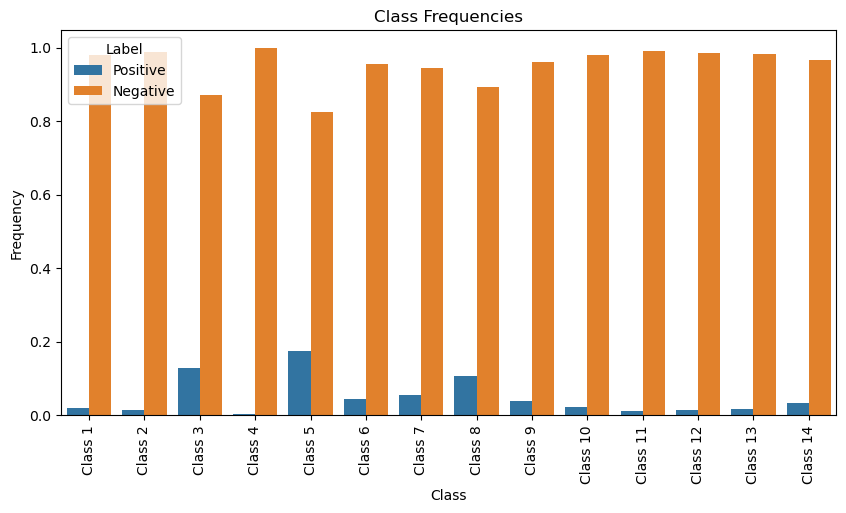

In [67]:
# Create DataFrame for positive frequencies
data_pos = pd.DataFrame({
    "Class": class_labels,
    "Label": ["Positive"] * len(freq_pos),
    "Value": freq_pos
})

# Create DataFrame for negative frequencies
data_neg = pd.DataFrame({
    "Class": class_labels,
    "Label": ["Negative"] * len(freq_neg),
    "Value": freq_neg
})

# Concatenate the two DataFrames
data = pd.concat([data_pos, data_neg], ignore_index=True)

# Visualize
plt.figure(figsize=(10, 5))
plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label", data=data)
plt.title('Class Frequencies')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.legend(title='Label')
plt.show()

As we see in the above plot, the contributions of positive cases is significantly lower than that of the negative ones. However, we want the contributions to be equal. One way of doing this is by multiplying each example from each class by a class-specific weight factor, $w_{pos}$ and $w_{neg}$, so that the overall contribution of each class is the same. 

To have this, we want 

$$w_{pos} \times freq_{p} = w_{neg} \times freq_{n},$$

which we can do simply by taking 

$$w_{pos} = freq_{neg}$$
$$w_{neg} = freq_{pos}$$

This way, we will be balancing the contribution of positive and negative labels.

In [44]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights

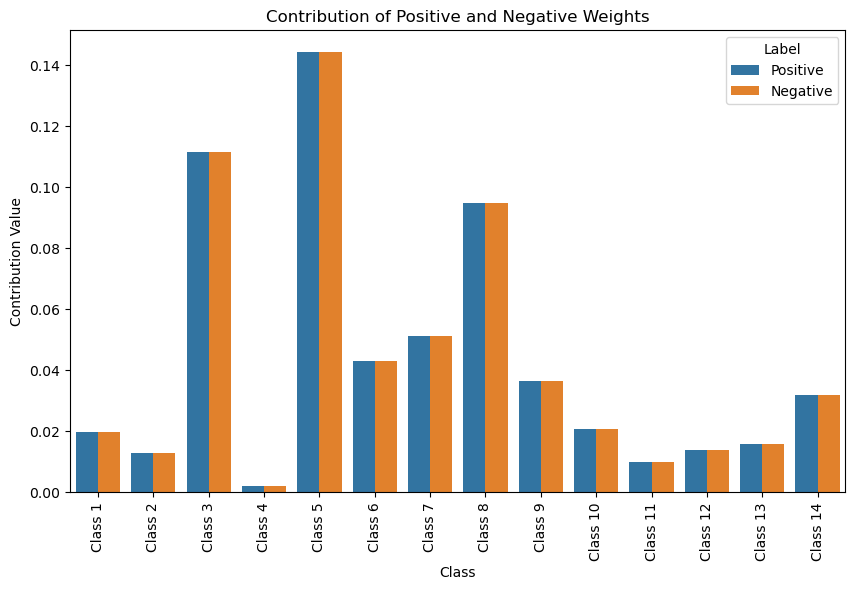

In [46]:
# Create DataFrame for positive contributions
class_labels = [f'Class {i+1}' for i in range(len(freq_pos))]
data_pos = pd.DataFrame({
    "Class": class_labels,
    "Label": "Positive",
    "Value": pos_contribution
})

# Create DataFrame for negative contributions
data_neg = pd.DataFrame({
    "Class": class_labels,
    "Label": "Negative",
    "Value": neg_contribution
})

# Concatenate the two DataFrames
data = pd.concat([data_pos, data_neg], ignore_index=True)

# Visualize
plt.figure(figsize=(10, 6))
plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label", data=data)
plt.title('Contribution of Positive and Negative Weights')
plt.xlabel('Class')
plt.ylabel('Contribution Value')
plt.legend(title='Label')
plt.show()

As the above figure shows, by applying these weightings the positive and negative labels within each class would have the same aggregate contribution to the loss function. Now let's implement such a loss function. 

After computing the weights, our final weighted loss for each training case will be 

$$\mathcal{L}_{cross-entropy}^{w}(x) = - (w_{p} y \log(f(x)) + w_{n}(1-y) \log( 1 - f(x) ) ).$$

### Weighted Loss
This is simply to avoid a numerical error that would otherwise occur if the predicted value happens to be zero.

In [50]:
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    def weighted_loss(y_true, y_pred):
        # Initialize loss to zero
        loss = 0.0
        
        # Ensure weights are tensors of the same type
        pos_weights_tensor = tf.convert_to_tensor(pos_weights, dtype=tf.float32)
        neg_weights_tensor = tf.convert_to_tensor(neg_weights, dtype=tf.float32)

        for i in range(len(pos_weights_tensor)): 
            loss += tf.reduce_mean(
                -(pos_weights_tensor[i] * y_true[:, i] * tf.math.log(y_pred[:, i] + epsilon) +
                  neg_weights_tensor[i] * (1 - y_true[:, i]) * tf.math.log(1 - y_pred[:, i] + epsilon))
            )
        return loss
    return weighted_loss


Let's test function with some simple cases.

In [53]:
# Test
print("Test example:\n")
y_true = tf.constant(np.array(
    [[1, 1, 1],
     [1, 1, 0],
     [0, 1, 0],
     [1, 0, 1]]
), dtype=tf.float32)  # Ensure y_true is float32
print("y_true:\n")
print(y_true.numpy())

w_p = np.array([0.25, 0.25, 0.5], dtype=np.float32)  # Ensure weights are float32
w_n = np.array([0.75, 0.75, 0.5], dtype=np.float32)
print("\nw_p:\n")
print(w_p)

print("\nw_n:\n")
print(w_n)

y_pred_1 = tf.constant(0.7 * np.ones(y_true.shape), dtype=tf.float32)  # Ensure y_pred is float32
print("\ny_pred_1:\n")
print(y_pred_1.numpy())

y_pred_2 = tf.constant(0.3 * np.ones(y_true.shape), dtype=tf.float32)  # Ensure y_pred is float32
print("\ny_pred_2:\n")
print(y_pred_2.numpy())

# Test with a large epsilon to catch errors
L = get_weighted_loss(w_p, w_n, epsilon=1)

print("\nIf we weighted them correctly, we expect the two losses to be the same.")
L1 = L(y_true, y_pred_1).numpy()
L2 = L(y_true, y_pred_2).numpy()
print(f"\nL(y_pred_1)= {L1:.4f}, L(y_pred_2)= {L2:.4f}")
print(f"Difference is L1 - L2 = {L1 - L2:.4f}")

Test example:

y_true:

[[1. 1. 1.]
 [1. 1. 0.]
 [0. 1. 0.]
 [1. 0. 1.]]

w_p:

[0.25 0.25 0.5 ]

w_n:

[0.75 0.75 0.5 ]

y_pred_1:

[[0.7 0.7 0.7]
 [0.7 0.7 0.7]
 [0.7 0.7 0.7]
 [0.7 0.7 0.7]]

y_pred_2:

[[0.3 0.3 0.3]
 [0.3 0.3 0.3]
 [0.3 0.3 0.3]
 [0.3 0.3 0.3]]

If we weighted them correctly, we expect the two losses to be the same.

L(y_pred_1)= -0.4956, L(y_pred_2)= -0.4956
Difference is L1 - L2 = 0.0000


## DenseNet121

In [62]:
# create the base pre-trained model
base_model = DenseNet121(weights='densenet.hdf5', include_top=False)

x = base_model.output

# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)

# and a logistic layer
predictions = Dense(len(labels), activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss=get_weighted_loss(pos_weights, neg_weights))

In [63]:
model.load_weights('pretrained_model.h5')

### Prediction and Evaluation

In [65]:
predicted_vals = model.predict(test_generator, steps = len(test_generator))

53/53 ━━━━━━━━━━━━━━━━━━━━ 38s 649ms/step


### ROC Curve and AUROC

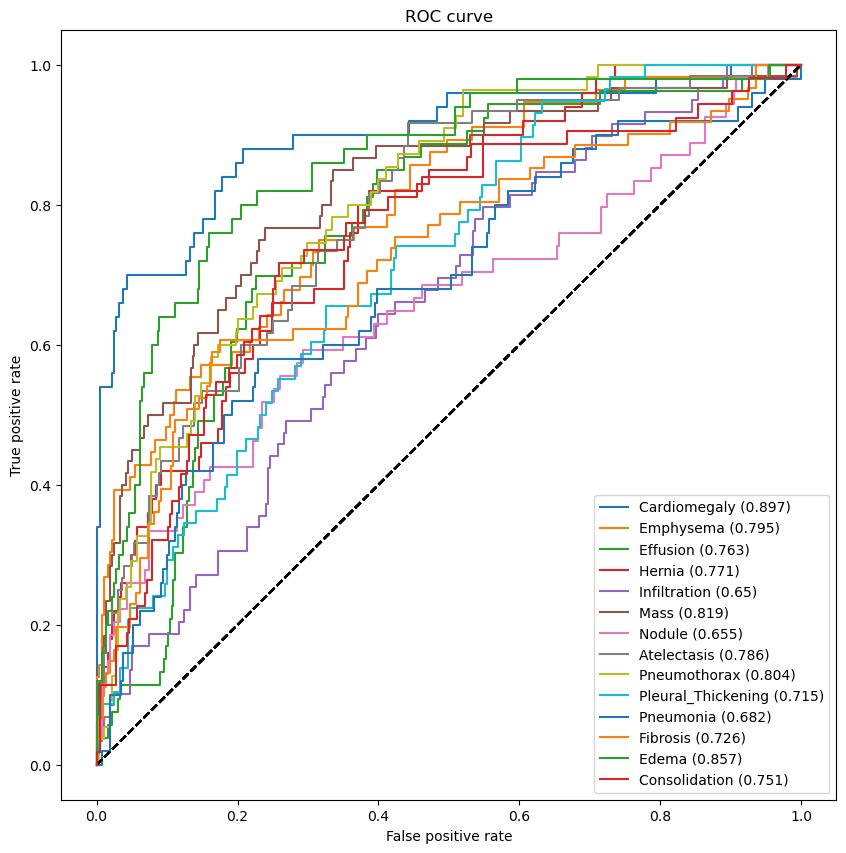

In [66]:
auc_rocs = util.get_roc_curve(labels, predicted_vals, test_generator)

### Visualizing Learning with GradCAM

In [73]:
df = pd.read_csv("train-small.csv")
IMAGE_DIR = "images-small/"

# only show the labels with top 4 AUC
labels_to_show = np.take(labels, np.argsort(auc_rocs)[::-1])[:4]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Loading original image
Generating gradcam for class Cardiomegaly
Generating gradcam for class Mass
Generating gradcam for class Pneumothorax
Generating gradcam for class Edema


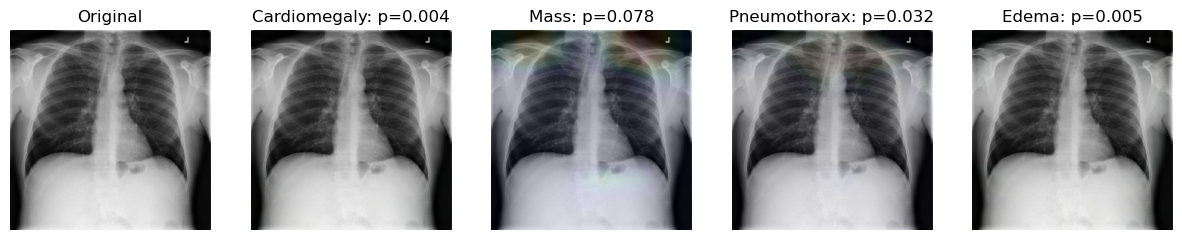

In [83]:
util.compute_gradcam(model, '00008270_015.png', IMAGE_DIR, df, labels, labels_to_show)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Loading original image
Generating gradcam for class Cardiomegaly
Generating gradcam for class Mass
Generating gradcam for class Pneumothorax
Generating gradcam for class Edema


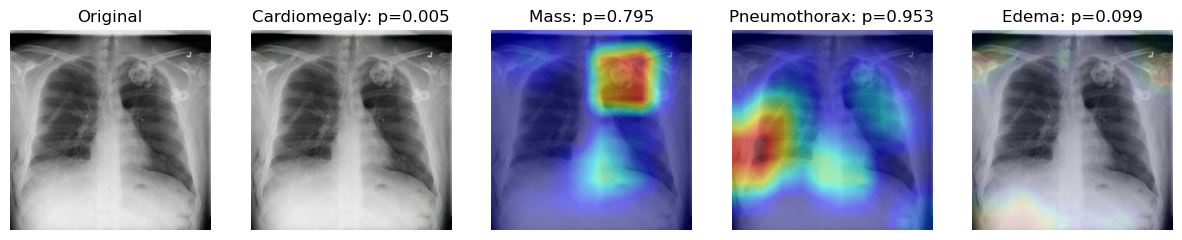

In [81]:
util.compute_gradcam(model, '00011355_002.png', IMAGE_DIR, df, labels, labels_to_show)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
Loading original image
Generating gradcam for class Cardiomegaly
Generating gradcam for class Mass
Generating gradcam for class Pneumothorax
Generating gradcam for class Edema


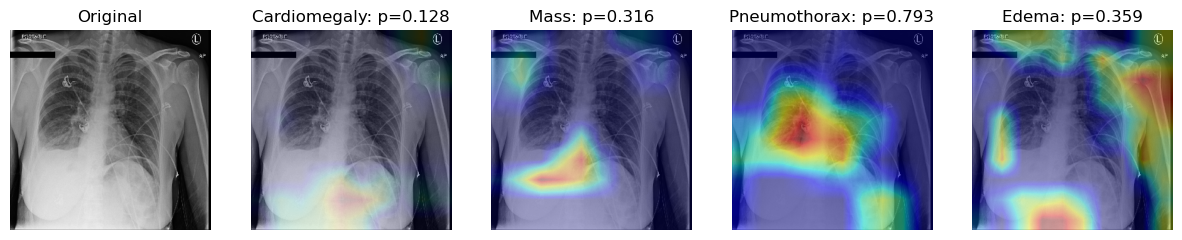

In [85]:
util.compute_gradcam(model, '00029855_001.png', IMAGE_DIR, df, labels, labels_to_show)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Loading original image
Generating gradcam for class Cardiomegaly
Generating gradcam for class Mass
Generating gradcam for class Pneumothorax
Generating gradcam for class Edema


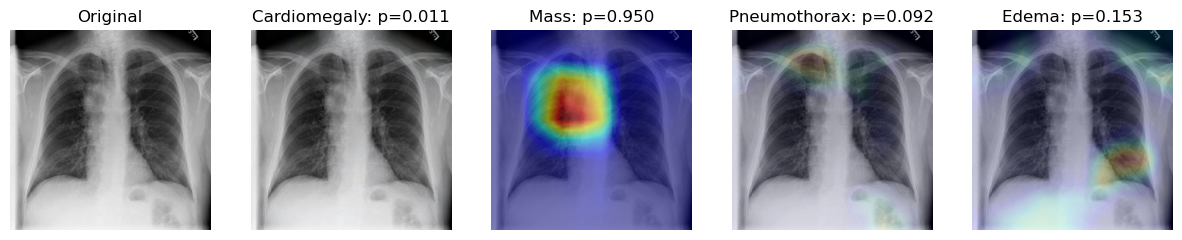

In [87]:
util.compute_gradcam(model, '00005410_000.png', IMAGE_DIR, df, labels, labels_to_show)